In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pymer4.models import Lmer
import sklearn

### Globals and functions

In [40]:
def bin_column(df, col, nbins, label_strategy = None, bin_strategy = 'quantiles'):
    precision = 3 if nbins > 10 else 1
    drop_dupes = nbins > 10
    if label_strategy == 'means':
        label_strategy = [f'{col}_bin_{i}' for i in range(nbins)] #not quite right
    if bin_strategy == 'quantiles':
        binned = pd.qcut(df[col], q=nbins, labels=label_strategy, duplicates='drop', precision = precision)
    elif bin_strategy == 'equal':
        binned = pd.cut(df[col], bins=nbins, labels=label_strategy, include_lowest = True)
    elif bin_strategy == 'readable_5':
        bins = [df[col].min(), 20] + list(range(22, 2+int(np.ceil(df[col].max())), 2))#list(range(5*int(df[col].min() // 5), 5+5*int(df[col].max() // 5), 5))
        binned = pd.cut(df[col], bins = bins, labels = label_strategy, include_lowest = True, right=False)
    elif bin_strategy == '0_1_more':
        _ , otherbins = pd.qcut(df.loc[df[col] > 1, col], q=nbins-2, retbins = True, duplicates = 'drop', precision = precision)
        otherbins[-1] = otherbins[-1]+1
        bins = [0,1] + list(otherbins)
        binned = pd.cut(df[col], bins=bins, labels = label_strategy, include_lowest = True, right=False)
    elif bin_strategy == '0_more':
        _ , otherbins = pd.qcut(df.loc[df[col] >= 1, col], q=nbins-2, retbins = True, duplicates='drop', precision = precision)
        otherbins[-1] = otherbins[-1]+1
        bins = [0,] + list(otherbins)
        binned = pd.cut(df[col], bins=bins, labels = label_strategy, include_lowest = True, right=False)
    else:
        raise ValueError('bin_strategy must be either "quantiles" or "equal"')
    return binned

def group_and_bin_column(df, group_cols, bin_col, nbins, bin_strategy = 'quantiles', label_strategy = None, result_column = None, keep_count = False):
    if result_column == None:
        result_column = bin_col + '_bin'
    grouped_df = df.groupby(group_cols + [bin_col], as_index=False).size()
    if not keep_count:
        grouped_df = grouped_df.drop(columns=['size'])
    grouped_df[result_column] = bin_column(grouped_df, bin_col, nbins, label_strategy, bin_strategy) 
    return pd.merge(df, grouped_df, how='left')
    
def group_and_bin_column_definition(df, bin_col, bin_category, nbins, bin_strategy = None, result_column = None):
    if bin_category == 'household':
        group_cols = ['nid', 'hh_id', 'psu', 'year_start']
        bin_strategy = 'quantiles' if bin_strategy is None else bin_strategy
    if bin_category == 'location':
        group_cols = ['lat', 'long']
        bin_strategy = 'quantiles' if bin_strategy is None else bin_strategy
    if bin_category == 'country':
        group_cols = ['iso3']
        bin_strategy = 'quantiles' if bin_strategy is None else bin_strategy
    return group_and_bin_column(df, group_cols, bin_col, nbins, bin_strategy = bin_strategy, result_column = result_column)

printable_names = {
        'income_per_day_bin':'Daily Income (2010 USD)',
        'temp_bin': 'Yearly Temperature (Mean)',
        'temp_bin_quants' : 'Mean Yearly Temperature',
        'temp_avg_bin' : 'Mean Temperature (5 year)',
        'precip_bin': 'Yearly Precipitation',
        'precip_avg_bin': 'Mean Yearly Precipitation (5 year avg)',
        'over30_bin': 'Days over 30° C',
        'over30_avg_bin': 'Days over 30° C (5 year avg)',
        'stunting': 'Stunting',
        'wasting':'Wasting',
        'underweight':'Underweight',
        'over30_avgperyear_bin' : 'Lifetime Yearly Average Days Above 30°C',
        'over30_birth_bin' : 'Days over 30 in year of birth', 
        'temp_diff_birth_bin': 'temp diff birth',
        'bmi': 'BMI',
        'low_adult_bmi' : 'Low adult BMI',
        'cgf_value': 'Stunting',
        'adjusted_pred' : 'Controlling for Country Effects',
        'predict_nocountry': 'Prediction without country',
        'residual': 'residual',
        'grid_coef' : 'dummy coefficient'
    }


def bin_cgf_cols(in_df, nbins):
    res_df = in_df.copy()
    res_df = group_and_bin_column_definition(res_df, 'income_per_day', 'household', nbins)
    res_df = group_and_bin_column_definition(res_df, 'over30', 'location', 10, bin_strategy = '0_more')
    res_df = group_and_bin_column_definition(res_df, 'temp', 'location', nbins, bin_strategy = 'readable_5')
    res_df = group_and_bin_column_definition(res_df, 'temp', 'location', nbins, bin_strategy = 'quantiles', result_column = 'temp_bin_quants')
    res_df = group_and_bin_column_definition(res_df, 'temp', 'location', 25, bin_strategy = 'equal', result_column = 'temp_bin_many')
    res_df = group_and_bin_column_definition(res_df, 'precip', 'location', nbins, bin_strategy = 'quantiles')
    res_df = group_and_bin_column_definition(res_df, 'over30_avgperyear', 'location', nbins, bin_strategy = '0_more')
    return res_df


#TODO Assert NAs and length here
# cols_to_verify = ['over30', 'over30_bin', 'temp', 'temp_bin', 'precip', 'precip_bin', 'income_per_day', 'income_per_day_bin',] 
#         #'over30_avg', 'over30_avg_bin', 'temp_avg', 'temp_avg_bin', 'precip_avg', 'precip_avg_bin']
# assert(merged_binned_df[cols_to_verify].notna().all().all())

def plot_cgf_varbins(plotcol):
    plot_binned_df = merged_binned_df.groupby([f'temp_bin_many', 'cgf_measure']).agg(
        col_value = (plotcol, 'mean'), cgf_value = ('cgf_value', 'sum'), cgf_denom = ('cgf_value', 'count')).reset_index()
    plot_binned_df = plot_binned_df.rename(columns = {'col_value' : plotcol})
    plot_binned_df['cgf_proportion'] = plot_binned_df['cgf_value'] / plot_binned_df['cgf_denom']
    plot_binned_df[f"temp_s"] = plot_binned_df[plotcol].astype(str)
    fig = px.line(plot_binned_df.sort_values(plotcol), x=plotcol, y='cgf_proportion', color = 'cgf_measure', title=f'CGF (proportion) by {plotcol}',
        hover_data = ['cgf_denom'])
    fig.show()

def plot_heatmap(df, temp_col, wealth_col = 'income_per_day_bin', country = None, year = None, margins = False, filter = None, value_col = 'cgf_value', title_addin = '', file=None):  
    plot_df = df
    if filter is not None:
        plot_df = plot_df.query(filter)
    if country:
        plot_df = plot_df[plot_df['iso3'] == country]
    if year:
        plot_df = plot_df[plot_df['year_start'] == year]

    plot_df = plot_df.rename(columns = printable_names)

    value_col = printable_names[value_col] if value_col in printable_names.keys() else value_col

    pivot_table_mean = plot_df.pivot_table(values=value_col, index=printable_names[wealth_col], 
        columns=printable_names[temp_col], aggfunc='mean', dropna=False, margins=margins, observed=False)
    pivot_table_count = plot_df.pivot_table(values=value_col, index=printable_names[wealth_col], 
        columns=printable_names[temp_col], aggfunc='count', dropna=False, margins=margins, observed=False)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table_mean, annot=True, fmt=".2f", cmap='RdYlBu_r')

    # Overlay the counts on the heatmap
    for i, row in enumerate(pivot_table_mean.values):
        for j, value in enumerate(row):
            plt.text(j+0.5, i+0.6, f'\n({pivot_table_count.values[i][j]})', 
                    ha="center", va="center");

    plt.title((f'{printable_names[wealth_col]} x {printable_names[temp_col]} \n x {title_addin}{value_col}' 
    f'(Mean Proportion & Count) {country if country else ", All Locations"}'));
    if file:
        plt.savefig(file)
    plt.show();
    plt.close()


### Globals, binning

In [41]:
cgf_measures = ['stunting', 'wasting']
merged_dfs = {measure: pd.read_parquet(f'/mnt/team/rapidresponse/pub/population/data/02-processed-data/cgf_bmi/cgf_{measure}.parquet') for measure in cgf_measures}
stunt_df = merged_dfs['stunting']
wast_df = merged_dfs['wasting']


In [42]:
nbins = 10
binned_stunt = bin_cgf_cols(stunt_df, nbins)
binned_wast = bin_cgf_cols(wast_df, nbins)
binned_stunt['grid_cell'] = binned_stunt.over30_avgperyear_bin.astype(str) +'_'+ binned_stunt.income_per_day_bin.astype(str)
binned_wast['grid_cell'] = binned_wast.over30_avgperyear_bin.astype(str) +'_'+ binned_wast.income_per_day_bin.astype(str)

cols_to_scale = ['over30_avgperyear', 'precip', 'precip_cumavg_5' ,'temp', 'temp_cumavg_5', 'income_per_day']
scaler = sklearn.preprocessing.MinMaxScaler()
scaled_cols = [f'sc_{col}' for col in cols_to_scale]
binned_stunt[scaled_cols] = scaler.fit_transform(binned_stunt[cols_to_scale])

/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [44]:
binned_stunt.columns

Index(['nid', 'iso3', 'geospatial_id_x', 'team', 'data_type', 'point_x', 'lat',
       'long', 'shapefile_x', 'location_code_x',
       ...
       'temp_bin_many', 'precip_bin', 'over30_avgperyear_bin', 'grid_cell',
       'sc_over30_avgperyear', 'sc_precip', 'sc_precip_cumavg_5', 'sc_temp',
       'sc_temp_cumavg_5', 'sc_income_per_day'],
      dtype='object', length=196)

### Random effects, Stunting

In [28]:
model_stunt_grid_only = Lmer('cgf_value ~ (1 | iso3) + (1 | grid_cell)', data=binned_stunt, family='binomial')

# Fit and print an R/statsmodels style summary 
# with t/z-tests, CIs, and p-values
model_stunt_grid_only.fit()

/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "income_per_day_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "over30_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "temp_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R fact

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: cgf_value~(1|iso3)+(1|grid_cell)

Family: binomial	 Inference: parametric

Number of observations: 759721	 Groups: {'grid_cell': 90.0, 'iso3': 43.0}

Log-likelihood: -481148.237 	 AIC: 962302.473

Random effects:

                  Name    Var    Std
grid_cell  (Intercept)  0.229  0.478
iso3       (Intercept)  0.113  0.336

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.599,-0.723,-0.475,0.063,0.549,0.485,0.622,0.355,0.327,0.383,-9.486,0.0,***


In [60]:
model_stunt_grid_sex = Lmer('cgf_value ~ sc_precip + sc_temp + sex + (1 | iso3) + (1 | grid_cell)', data=binned_stunt, family='binomial')
model_stunt_grid_sex.fit()

/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "income_per_day_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "over30_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "temp_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R fact

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: cgf_value~sc_precip+sc_temp+sex+(1|iso3)+(1|grid_cell)

Family: binomial	 Inference: parametric

Number of observations: 759721	 Groups: {'grid_cell': 90.0, 'iso3': 43.0}

Log-likelihood: -480082.531 	 AIC: 960177.062

Random effects:

                  Name    Var    Std
grid_cell  (Intercept)  0.244  0.494
iso3       (Intercept)  0.121  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.541,0.379,0.702,0.082,1.717,1.462,2.017,0.632,0.594,0.669,6.575,0.000,***
sc_precip,-0.124,-0.206,-0.043,0.042,0.883,0.814,0.958,0.469,0.449,0.489,-2.988,0.003,**
sc_temp,-1.414,-1.500,-1.329,0.044,0.243,0.223,0.265,0.196,0.182,0.209,-32.388,0.000,***
sex,0.158,0.149,0.168,0.005,1.171,1.160,1.183,0.539,0.537,0.542,32.344,0.000,***


In [45]:
model_stunt_grid_all = Lmer('cgf_value ~ sc_precip + sc_temp + (1 | iso3) + (1 | grid_cell)', data=binned_stunt, family='binomial')
model_stunt_grid_all.fit()

/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "income_per_day_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "over30_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "temp_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R fact

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: cgf_value~sc_precip+sc_temp+(1|iso3)+(1|grid_cell)

Family: binomial	 Inference: parametric

Number of observations: 759721	 Groups: {'grid_cell': 90.0, 'iso3': 43.0}

Log-likelihood: -480606.187 	 AIC: 961222.374

Random effects:

                  Name    Var    Std
grid_cell  (Intercept)  0.243  0.493
iso3       (Intercept)  0.120  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.622,0.466,0.778,0.080,1.863,1.594,2.177,0.651,0.614,0.685,7.815,0.000,***
sc_precip,-0.129,-0.210,-0.047,0.041,0.879,0.811,0.954,0.468,0.448,0.488,-3.100,0.002,**
sc_temp,-1.413,-1.499,-1.328,0.043,0.243,0.223,0.265,0.196,0.183,0.209,-32.554,0.000,***


In [47]:
binned_stunt['fit_REgrid_all'] = model_stunt_grid_all.fits
binned_stunt['fit_REgrid_only'] = model_stunt_grid_only.fits


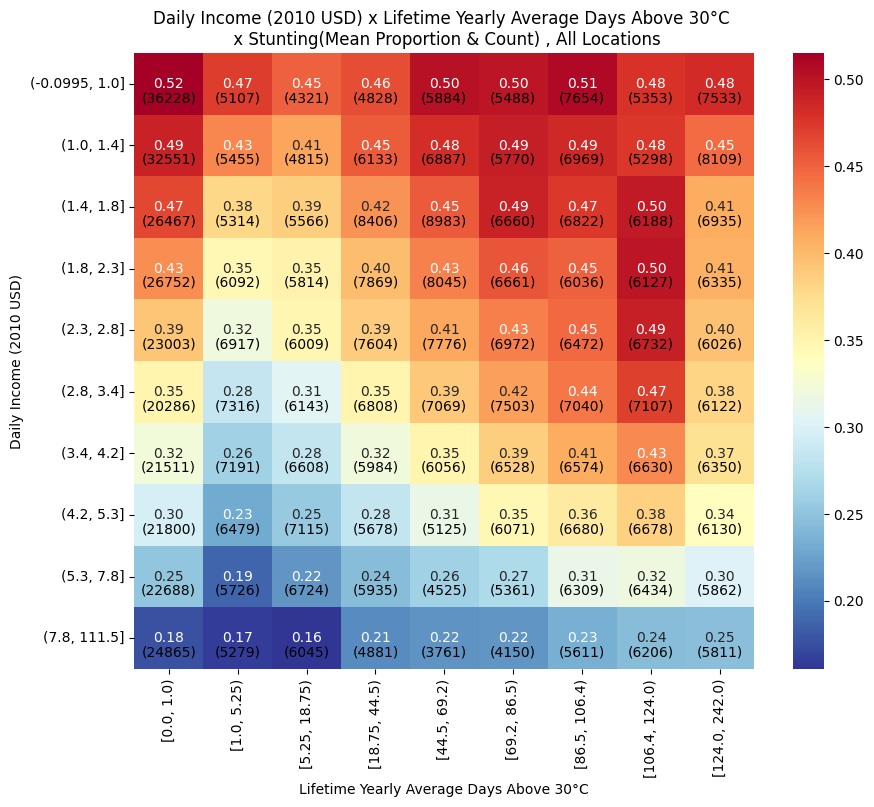

In [57]:
plot_heatmap(binned_stunt, 'over30_avgperyear_bin', value_col='cgf_value', title_addin='')

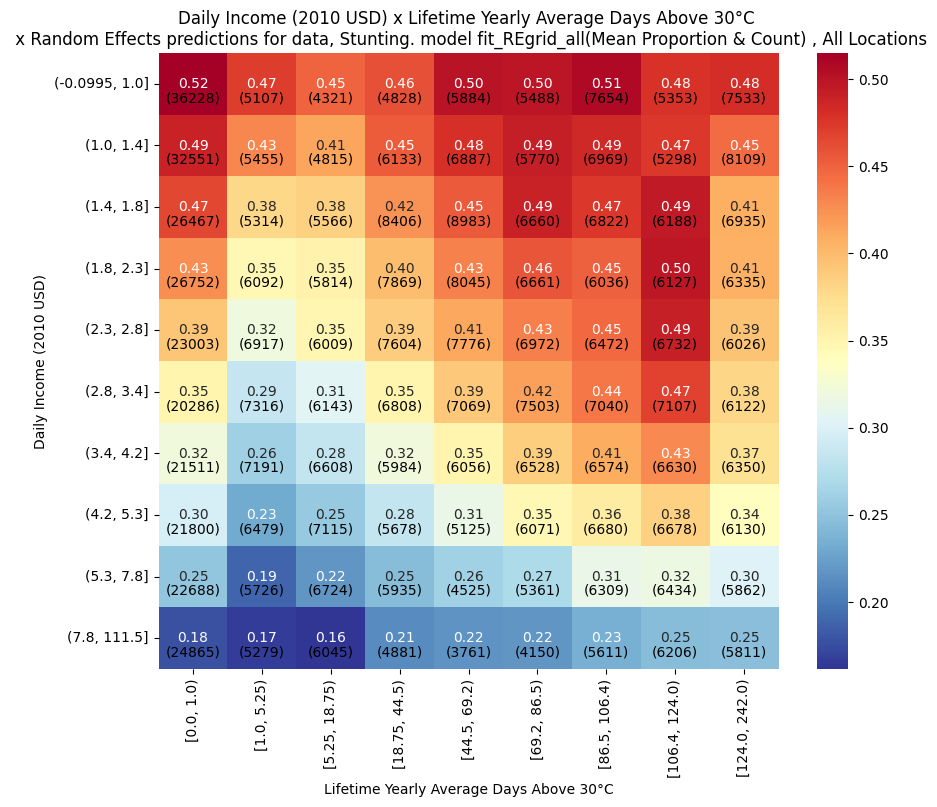

In [48]:
plot_heatmap(binned_stunt, 'over30_avgperyear_bin', value_col='fit_REgrid_all', title_addin='Random Effects predictions for data, Stunting. model ')

In [ ]:
pred_stunt = binned_stunt[scaled_cols + cols_to_scale + 'iso3' + 'coef']

### Evaluation

In [49]:
sklearn.metrics.roc_auc_score(binned_stunt.cgf_value, binned_stunt.fit_REgrid_all)

0.6456616162126563

In [50]:
sklearn.metrics.roc_auc_score(binned_stunt.cgf_value, binned_stunt.fit_REgrid_only)

0.6441448130421119

### Predicting without country effect

In [56]:
# pred_stunt = binned_stunt[cols_to_scale + scaled_cols + ['cgf_value', 'iso3', 'grid_cell', 'income_per_day_bin', 'over30_avgperyear_bin']].copy()
# pred_stunt['iso3'] = np.nan
# preds = model_stunt_grid_all.predict(pred_stunt)
# pred_stunt['predict_nocountry_REall'] = preds
preds2 = model_stunt_grid_only.predict(pred_stunt)
pred_stunt['predict_nocountry_REonly'] = preds2



/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "income_per_day_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "over30_avgperyear_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/mnt/share/homes/victorvt/envs/cgf_temperature/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "over30_bin". Fall back to string conversion. The error is: Converting pandas "Category" ser

In [ ]:
pred_stunt

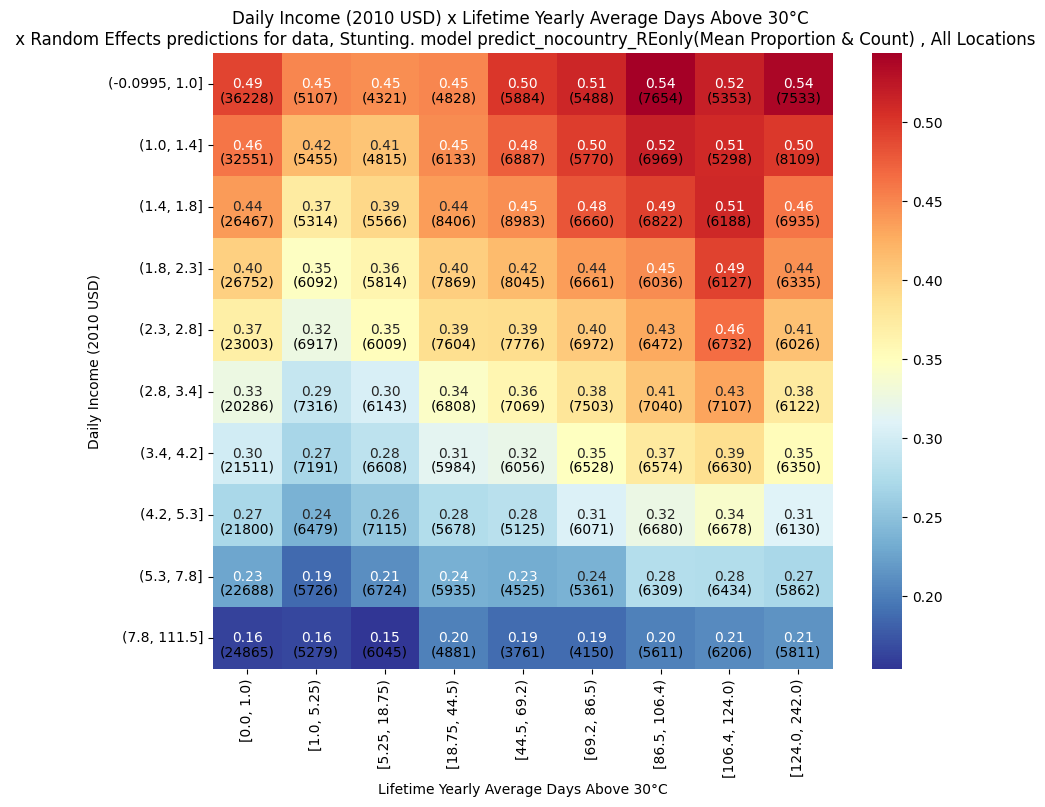

In [59]:
plot_heatmap(pred_stunt, 'over30_avgperyear_bin', value_col='predict_nocountry_REonly', title_addin='Random Effects predictions for data, Stunting. model ')